# LSTM을 이용한 로이터 뉴스 카테고리 분류하기

In [22]:
# 로이터 뉴스 데이터셋 불러오기
from keras.datasets import reuters
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding
from keras.preprocessing import sequence
from keras.utils import np_utils
from keras.callbacks import EarlyStopping

import numpy
import tensorflow as tf
import matplotlib.pyplot as plt

In [3]:
# seed 값 설정
seed = 0
numpy.random.seed(seed)
tf.set_random_seed(seed)

In [12]:
# 불러온 데이터를 학습셋, 테스트셋으로 나누기
old = np.load
np.load = lambda *a,**k: old(*a,**k,allow_pickle=True)  # kaggle에서 데이터를 읽기위한 방법 추가 

from keras.datasets import reuters
(X_train, Y_train), (X_test, Y_test) = reuters.load_data(num_words=1000, test_split=0.2)

np.load = old
del(old)

# tset.split : 테스스셋 vs 검증셋 비율 설정
# num_words : 단어의 빈도가 1 ~ 1000에 해당하는 단어만 불러오기 

In [13]:
# 데이터 확인하기
category = numpy.max(Y_train) + 1
print(category, '카테고리')
print(len(X_train), '학습용 뉴스 기사')
print(len(X_test), '테스트용 뉴스 기사')
print(X_train[0])  # 여기서 숫자는 데이터 안에서 해당 단어가 몇번이나 나타나는지 세어 빈도에 따라 번호를 붙인 것
# 예를들어 3이라는 숫자는 세 번째로 빈도가 높은 단어라는 의미, 즉 숫자가 작을수록 빈도가 큼 


46 카테고리
8982 학습용 뉴스 기사
2246 테스트용 뉴스 기사
[1, 2, 2, 8, 43, 10, 447, 5, 25, 207, 270, 5, 2, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 2, 2, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 2, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]


In [14]:
# 데이터 전처리
x_train = sequence.pad_sequences(X_train, maxlen=100) # 단어의 수를 100개로 맞춘다. 
x_test = sequence.pad_sequences(X_test, maxlen=100)
y_train = np_utils.to_categorical(Y_train) # 카테고리를 원-핫 인코딩 
y_test = np_utils.to_categorical(Y_test)

In [17]:
# 모델의 설정
model = Sequential()
model.add(Embedding(1000, 1000)) # 데이터 전처리 과정을 통해 입력된 값을 받아 다음 층이 알아들을 수 있는 형태로 변환 
# Embedding('불러온 단어의 총 개수(위의 num_words)', '기사당 단어 수(maxlen)'), 모델 설정 부분의 맨 처음에 있어야 한다.

model.add(LSTM(1000, activation='tanh')) # (LSTM('기사당 단어 수', 기타 옵션), tanh 활성화 함수)
model.add(Dense(46, activation='softmax'))

In [25]:
# 모델의 컴파일
model.compile(loss='categorical_crossentropy',
            optimizer='adam',
            metrics=['accuracy'])

# 조기 종료 설정 
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5)

In [26]:
# 모델의 실행
history = model.fit(x_train, y_train, batch_size=100, epochs=30, 
                    validation_data=(x_test, y_test), callbacks=[early_stopping_callback])

Train on 8982 samples, validate on 2246 samples
Epoch 1/30
8982/8982 [==============================] - 19s 2ms/step - loss: 1.9573 - acc: 0.5116 - val_loss: 1.7882 - val_acc: 0.5543
Epoch 2/30
8982/8982 [==============================] - 17s 2ms/step - loss: 1.7369 - acc: 0.5577 - val_loss: 1.7328 - val_acc: 0.5632
Epoch 3/30
8982/8982 [==============================] - 17s 2ms/step - loss: 1.4954 - acc: 0.6185 - val_loss: 1.4224 - val_acc: 0.6291
Epoch 4/30
8982/8982 [==============================] - 17s 2ms/step - loss: 1.2532 - acc: 0.6829 - val_loss: 1.2616 - val_acc: 0.6736
Epoch 5/30
8982/8982 [==============================] - 17s 2ms/step - loss: 1.1047 - acc: 0.7207 - val_loss: 1.1472 - val_acc: 0.7182
Epoch 6/30
8982/8982 [==============================] - 18s 2ms/step - loss: 0.9696 - acc: 0.7523 - val_loss: 1.1005 - val_acc: 0.7253
Epoch 7/30
8982/8982 [==============================] - 17s 2ms/step - loss: 0.8653 - acc: 0.7799 - val_loss: 1.0804 - val_acc: 0.7271
Epoch 8

In [27]:
# 테스트 정확도 출력
print("\n Test Accuracy: %.4f" % (model.evaluate(x_test, y_test)[1]))

2246/2246 [==============================] - 2s 949us/step

 Test Accuracy: 0.7257


In [28]:
import numpy as np

# 데이터 

y_loss = history.history['loss']        # 훈련 손실값
y_vloss = history.history['val_loss']   # 검증 손실값

y_acc = history.history['acc']          # 훈련 정확도 
y_vacc = history.history['val_acc']     # 검증 정확도

x_len = np.arange(1, len(y_loss)+1)     # x축 데이터

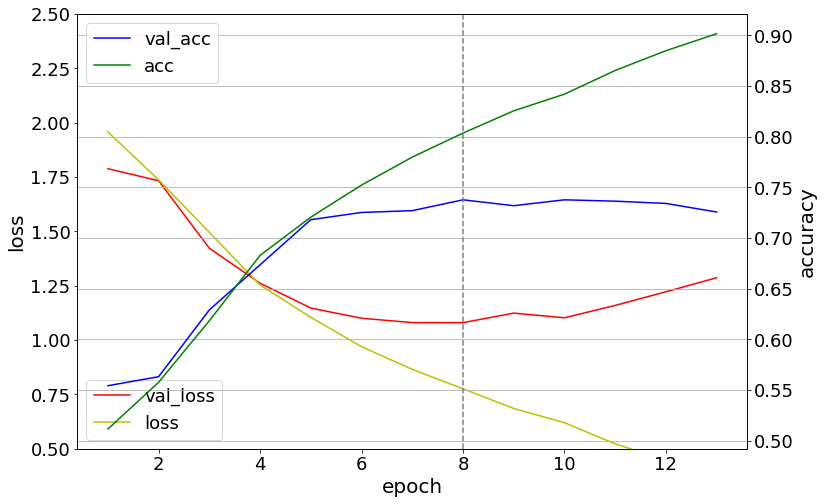

In [30]:
plt.rcParams["font.size"] = 18
plt.figure(figsize=(12, 8))

ax1, ax2= plt.gca(), plt.gca().twinx() # 원래 주어진 axis, x를 공유하는 쌍둥이 axis 
ax1.plot(x_len, y_vloss, color='red', label='val_loss')
ax1.plot(x_len, y_loss, color='y', label='loss')
ax2.plot(x_len, y_vacc, color='b', label='val_acc')
ax2.plot(x_len, y_acc, color='g', label='acc')

ax1.set_ylim((0.5, 2.5))
ax1.set_xlabel('epoch', size=20)  # 라벨 설정 
ax1.set_ylabel('loss', size=20)
ax2.set_ylabel('accuracy', size=20)

ax1.legend(loc='lower left')
ax2.legend(loc='upper left')

plt.axvline(x=8, color='grey', linestyle='--')
plt.grid()
plt.show()